In [1]:
import pandas as pd
import numpy as np
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# 全局设置字体及大小，设置公式字体即可，若要修改刻度字体，可在此修改全局字体
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,# 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 #分辨率

In [2]:
df_hse = pd.read_csv('./data/data.csv',index_col=0)
df_exp = pd.read_csv('./data/exp_data.csv')
df_hse['formula'] = df_hse['formula'].apply(lambda x: Composition(x).reduced_formula)
df_exp['formula'] = df_exp['formula'].apply(lambda x: Composition(x).reduced_formula)
merged = pd.merge(df_hse, df_exp[['formula', 'gap']], on='formula')

In [3]:
duplicated=merged['formula'].duplicated()
counts = duplicated.value_counts()
counts

False    3918
True     2610
Name: formula, dtype: int64

In [4]:
#比较重复值，选择差值小的那一行
def choose_row(group):
    hse_diff = np.abs(group["target"].diff())
    gap_diff = np.abs(group["gap"].diff())
    hse_diff.iloc[0] = np.inf
    gap_diff.iloc[0] = np.inf
    if hse_diff.min() <= gap_diff.min():
        return group.iloc[hse_diff.argmin()]
    else:
        return group.iloc[gap_diff.argmin()]
unique_merged = merged.groupby("formula").apply(choose_row).reset_index(drop=True)

In [5]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_test = r2_score(unique_merged['target'], unique_merged['gap'])
mae = mean_absolute_error(unique_merged['target'], unique_merged['gap'])
rmse = mean_squared_error(unique_merged['target'], unique_merged['gap'], squared=False)
textstr = f'R2 = {r2_test:.2f} MAE = {mae:.2f}  RMSE = {rmse:.2f}'
textstr

'R2 = 0.73 MAE = 0.35  RMSE = 0.78'

Text(0, 0.5, 'Measured Band Gap (eV)')

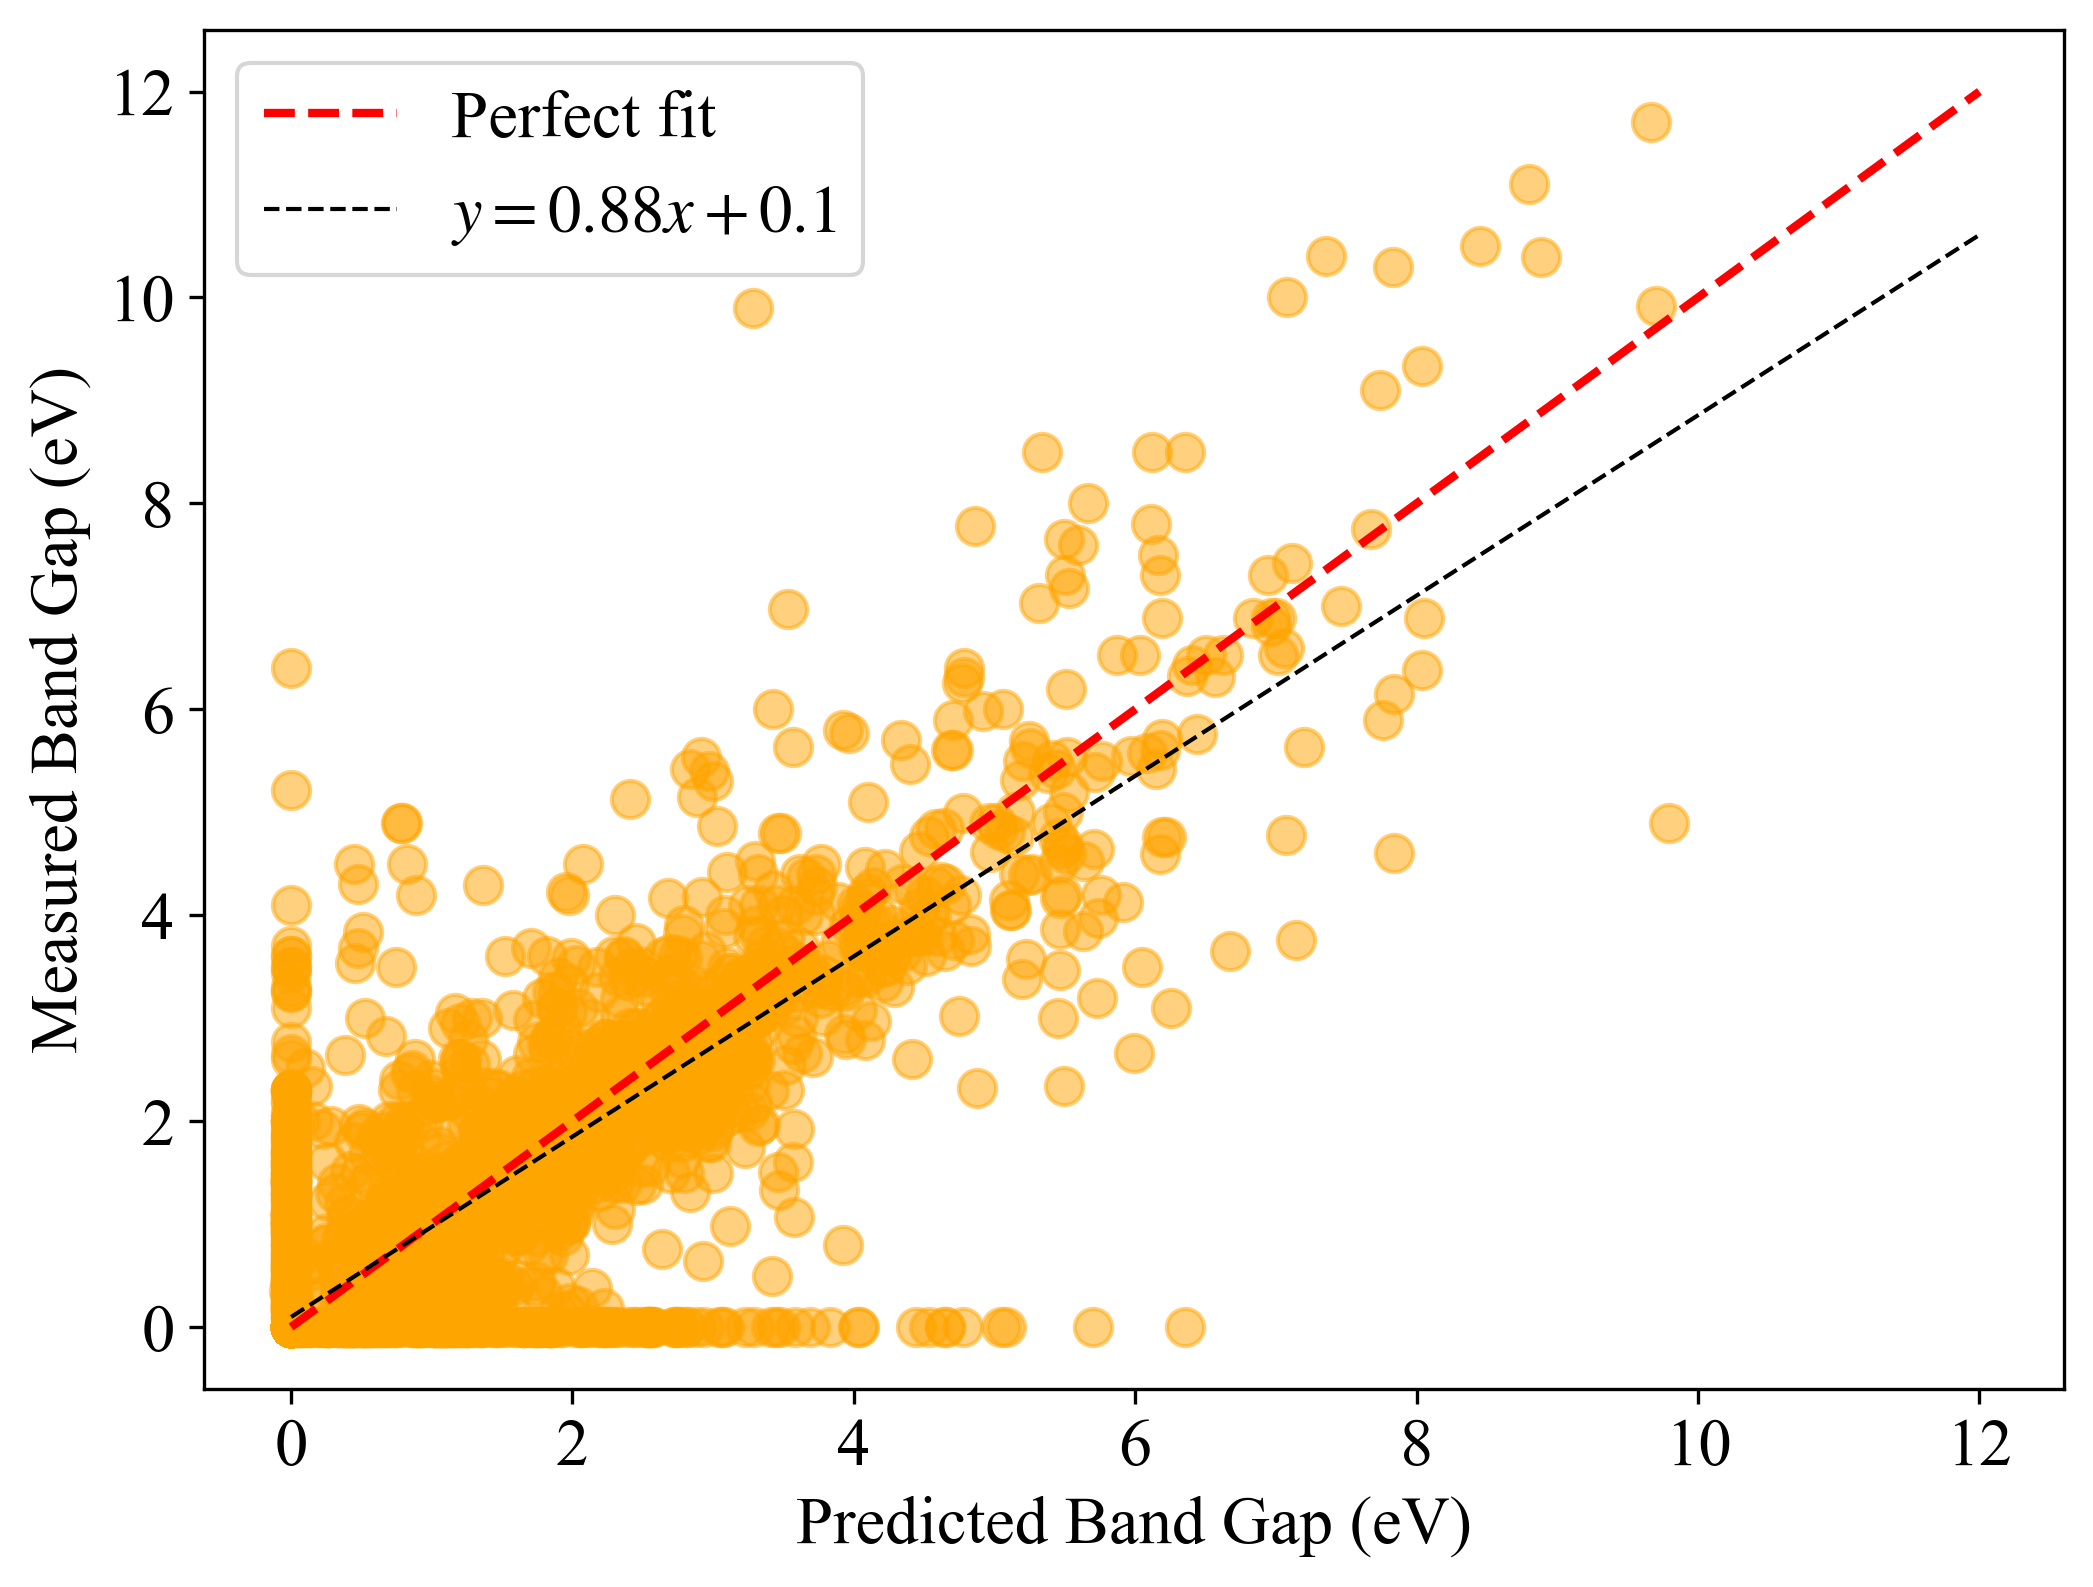

In [6]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
fig, ax = plt.subplots(figsize=(8,6),facecolor="w")
ridge.fit(unique_merged['target'].values.reshape(-1, 1), unique_merged['gap'].values.reshape(-1, 1))
ax.scatter(unique_merged['target'], unique_merged['gap'], facecolor='orange',s=80,  alpha=0.5)
ax.plot([0, 12], [0, 12],  'r--',lw=2,label='Perfect fit')
ax.plot([0, 12], [(0*ridge.coef_+ridge.intercept_)[0], (12*ridge.coef_+ridge.intercept_)[0]],
        'k--', lw=1, label=r'$ y = 0.88 x + 0.1 $')
ax.legend()
ax.set_xlabel("Predicted Band Gap (eV)")
ax.set_ylabel("Measured Band Gap (eV)")

In [7]:
unique_merged_GGA = unique_merged[unique_merged['GGA']!=unique_merged['target']]
print(unique_merged_GGA.shape)
r2_test = r2_score(unique_merged['GGA'], unique_merged['gap'])
mae = mean_absolute_error(unique_merged['GGA'], unique_merged['gap'])
rmse = mean_squared_error(unique_merged['GGA'], unique_merged['gap'], squared=False)
textstr = f'R2 = {r2_test:.2f} MAE = {mae:.2f}  RMSE = {rmse:.2f}'
textstr

(1398, 5)


'R2 = 0.36 MAE = 0.41  RMSE = 0.86'

Text(0, 0.5, 'Measured Band Gap (eV)')

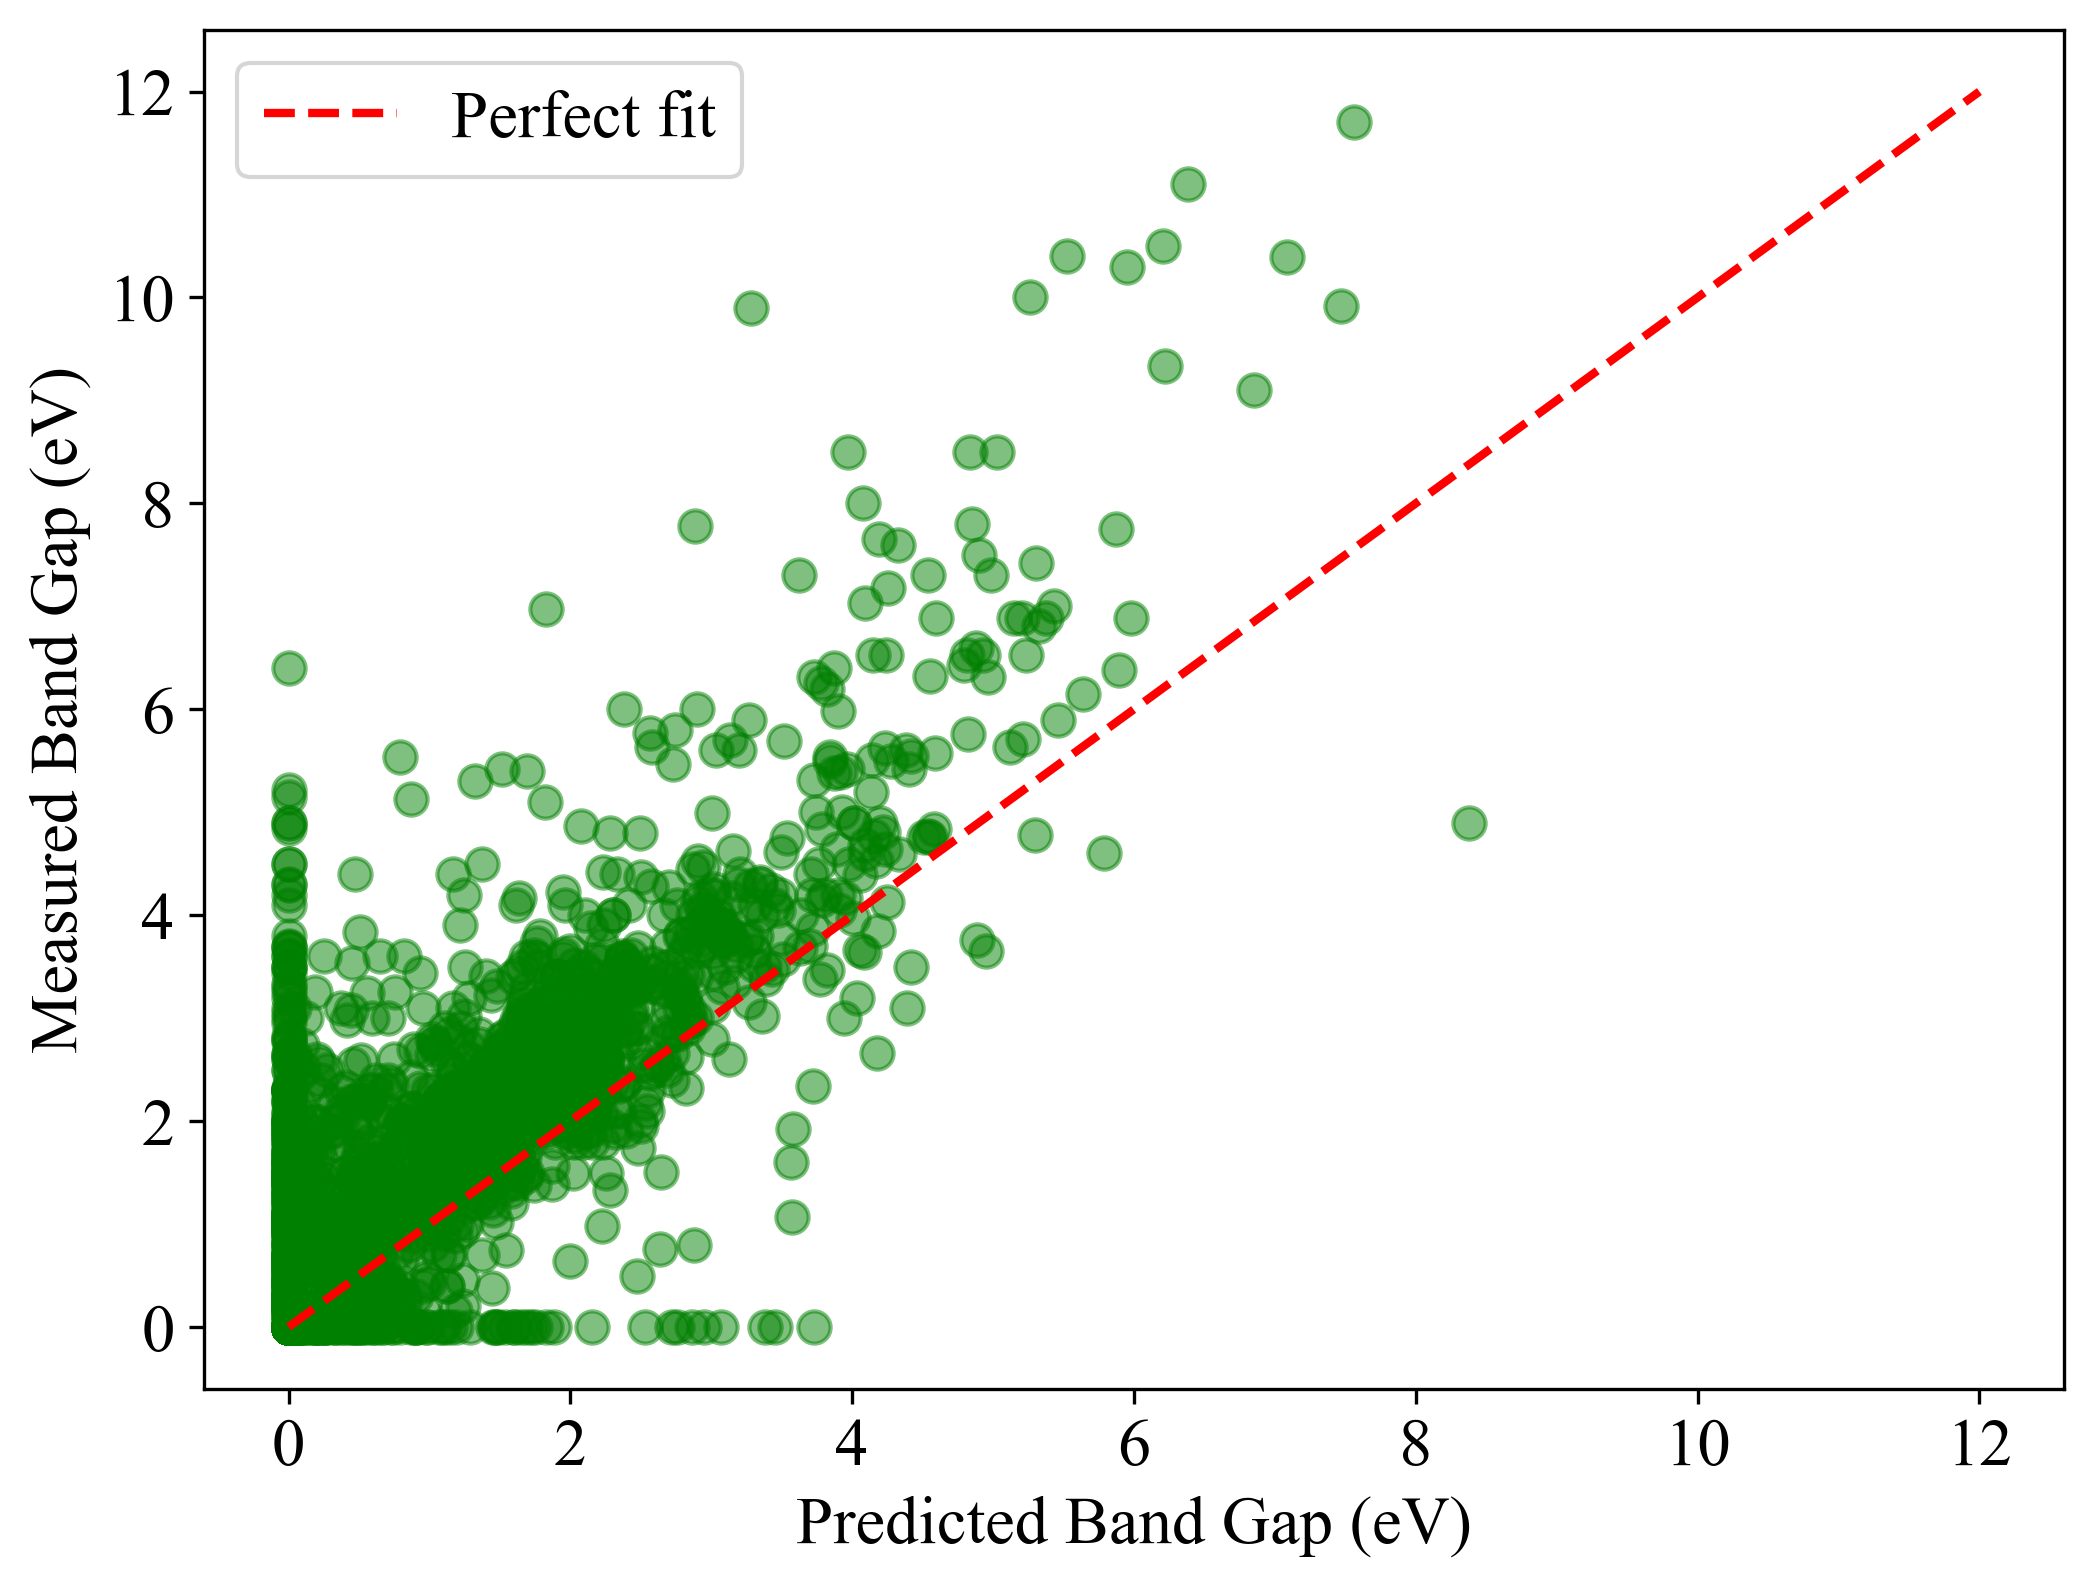

In [8]:
fig, ax = plt.subplots(figsize=(8,6),facecolor="w")
ridge.fit(unique_merged['GGA'].values.reshape(-1, 1), unique_merged['gap'].values.reshape(-1, 1))
ax.scatter(unique_merged['GGA'], unique_merged['gap'], facecolor='g',s=60,  alpha=0.5)
ax.plot([0, 12], [0, 12],  'r--',lw=2,label='Perfect fit')
# ax.plot([0, 12], [(0*ridge.coef_+ridge.intercept_)[0], (12*ridge.coef_+ridge.intercept_)[0]],
#         'k--', lw=1, label=r'$ y = 1.06 x + 0.66 $')
ax.legend()
ax.set_xlabel("Predicted Band Gap (eV)")
ax.set_ylabel("Measured Band Gap (eV)")